In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyreadr
import cmdstanpy
import geopandas as gpd

In [2]:
def spline_values(input, order, ext_knots):
    if np.isnan(input).sum() > 0:
        raise ValueError("nan values in input")
    knots = ext_knots
    B = np.zeros((input.shape[0], len(knots)-order))
    if order==1:
        for i in range(B.shape[1]):
            B[:, i] = (input >= knots[i])&(input<knots[i+1])
    else:
        B_low = spline_values(input, order-1, knots)
        for i in range(B.shape[1]):
            left_denom = knots[i+order-1] - knots[i]
            right_denom = knots[i+order] - knots[i+1]

            left_term = 0.0
            right_term = 0.0

            if left_denom != 0:
                left_term = (input - knots[i]) / left_denom * B_low[:, i]
            if right_denom != 0:
                right_term = (knots[i+order] - input) / right_denom * B_low[:, i+1]

            B[:, i] = left_term + right_term
    return B

---

## CAR structure (move this to after definition of data, so that NAN values are reflected in the adjacency)

In [3]:
adj_df = pd.read_csv('0-Data/base_info/admin2_adjacency.csv', index_col=0)
W = np.array(adj_df)
D = np.diag(np.sum(W, axis=1))

isolated_regions = np.where(np.sum(W, axis=1) == 0)[0]
non_isolated_regions = np.where(np.sum(W, axis=1) != 0)[0]
isolated_regions_index = (isolated_regions + 1).tolist()
non_isolated_regions_index = (non_isolated_regions + 1).tolist()

n_isolated_regions = len(isolated_regions)
n_non_isolated_regions = len(non_isolated_regions)

non_isolated_W = W[np.ix_(non_isolated_regions, non_isolated_regions)]
non_isolated_D = np.diag(np.sum(non_isolated_W, axis=1))

# some regions have no neighbours
non_isolated_D_inv_sqrt = np.diag(1.0 / np.sqrt(np.sum(non_isolated_W, axis=1)))
weighted_non_isolated_W = non_isolated_D_inv_sqrt @ non_isolated_W @ non_isolated_D_inv_sqrt

weighted_eigenvalues, weighted_eigenvectors = np.linalg.eigh(weighted_non_isolated_W)

pos_evalues = weighted_eigenvalues[weighted_eigenvalues > 0]
neg_evalues = weighted_eigenvalues[weighted_eigenvalues < 0]
alpha_bounds = [1/min(neg_evalues), 1/max(pos_evalues)]

In [ ]:
# 1. Extract sparse adjacency (i, j) where W[i,j] > 0
rows, cols = np.where(non_isolated_W > 0)
# keep only one direction: i < j
mask = rows < cols
rows = rows[mask]
cols = cols[mask]
# Stan requires 1-based indexing
W_sparse = np.vstack((rows + 1, cols + 1))  # shape (2, W_n)
W_n = len(rows)
# 2. Edge weights (usually W contains 1s)
W_weight = non_isolated_W[rows, cols].astype(float)
# 3. Diagonal elements of D (row sums of adjacency)
non_isolated_D_diag = np.sum(non_isolated_W, axis=1).astype(float)

---

## Data

In [7]:
valid_admin = pd.read_csv(f'0-Data/base_info/admin2_unique.csv', header=None)[0].tolist()

### Static (surveillance, urbanisation)

In [8]:
surveillance = pyreadr.read_r('0-Data/dengue_indonesia_yifan/data/surveillance_admin2.rds')[None][['admin2',
                                                    'surveillance_pop_pct', 'surveillance_area_pct']] 
surveillance = surveillance[surveillance[f'admin2'].isin(valid_admin)].reset_index(drop=True)
##
urban_surveillance = pyreadr.read_r('0-Data/dengue_indonesia_yifan/data/urban_surveillance_admin2.rds')[None][['admin2',
                                                    'surveillance_pop_pct', 'surveillance_area_pct']] 
urban_surveillance = urban_surveillance[urban_surveillance[f'admin2'].isin(valid_admin)].reset_index(drop=True)
urban_surveillance.columns = ['admin2', 'urban_surveillance_pop_pct', 'urban_surveillance_area_pct']
##

##
urbanisation = pyreadr.read_r('0-Data/dengue_indonesia_yifan/data/urbanisation_admin2.rds')[None][['admin2',
                                                        'urban_pop_pct_binary', 'urban_area_pct_binary']]
urbanisation = urbanisation[urbanisation[f'admin2'].isin(valid_admin)].reset_index(drop=True)
urbanisation.columns = ['admin2', 'urban_pop_pct', 'urban_area_pct']
##

##
areas = pd.read_csv("0-Data/base_info/admin2_area.csv")
areas = areas[areas[f'admin2'].isin(valid_admin)].reset_index(drop=True)
##

static_features = surveillance.merge(urban_surveillance, left_on='admin2', right_on='admin2', how='inner')
static_features = static_features.merge(urbanisation, left_on='admin2', right_on='admin2', how='inner')
static_features = static_features.merge(areas, left_on='admin2', right_on='admin2', how='inner')


In [9]:
static_features.loc[np.sum(static_features.isna(), axis=1)>0]

,admin2,surveillance_pop_pct,surveillance_area_pct,urban_surveillance_pop_pct,urban_surveillance_area_pct,urban_pop_pct,urban_area_pct,area_km2
155,KEPULAUAN SERIBU,NaN,NaN,NaN,NaN,5.430159,5.430159,7.936481
260,KOTA TARAKAN,NaN,NaN,NaN,NaN,84.451240,23.737426,250.636055


In [10]:
static_features

,admin2,surveillance_pop_pct,surveillance_area_pct,urban_surveillance_pop_pct,urban_surveillance_area_pct,urban_pop_pct,urban_area_pct,area_km2
0,ACEH BARAT,63.992208,37.401369,0.795744,0.295395,20.510985,1.810541,2810.882757
1,ACEH BARAT DAYA,74.951720,29.938012,26.549432,2.466479,61.217582,3.856479,1893.612683
2,ACEH BESAR,85.829312,51.961601,39.604837,6.947352,59.075063,9.890427,2897.867095
3,ACEH JAYA,57.361519,23.910111,0.633501,0.202669,22.367670,1.093738,3878.099322
4,ACEH SELATAN,50.176042,23.518889,7.750985,1.256892,42.700562,3.484051,4215.641283
...,...,...,...,...,...,...,...,...
509,WAY KANAN,53.264678,51.474440,2.916697,2.855169,5.894580,4.202010,3651.256522
510,WONOGIRI,88.806373,83.792472,57.564318,41.487494,69.679284,45.907655,1923.196286
511,WONOSOBO,89.385170,84.936488,61.584753,45.740286,80.839556,54.375058,994.069213
512,YAHUKIMO,6.240387,5.732877,0.229006,0.156742,1.392112,0.867185,14615.858523


### Weather Variables

In [11]:
mean_temp = pyreadr.read_r("0-Data/dengue_indonesia_yifan/data/temp_monthly_admin2.rds")[None]
mean_temp['date'] = pd.to_datetime(mean_temp['date']).dt.strftime('%Y-%m')
mean_temp = mean_temp.rename(columns={'temperature_celsius':'mean_temp', 'temperature_celsius_pop_weighted':'mean_temp_popw'})

### Cases and merging

In [12]:
incidence = pyreadr.read_r('0-Data/dengue_indonesia_yifan/data/data_cases_deaths_pop_2016_2024_38.rds')[None]
incidence['date'] = incidence['year'].astype(int).astype(str) + '-' + incidence['month'].astype(int).astype(str).str.zfill(2)
incidence = incidence[incidence['date'] <= '2020-04']
incidence = incidence[incidence['month']==1.0]
incidence.sort_values(['date', 'admin2'], inplace=True)

incidence = incidence.merge(static_features, how='left', left_on='admin2', right_on='admin2')
incidence = incidence.merge(mean_temp[['date', 'admin2', 'mean_temp', 'mean_temp_popw']], how='left', left_on=['admin2', 'date'], right_on=['admin2', 'date'])

In [13]:
incidence['urban_density'] = incidence['urban_pop_pct']*incidence['pop'] / (incidence['urban_area_pct']*incidence['area_km2'])

In [14]:
incidence

,region,idadmin1,idadmin2,admin1,admin2,year,month,cases,deaths,pop,...,surveillance_pop_pct,surveillance_area_pct,urban_surveillance_pop_pct,urban_surveillance_area_pct,urban_pop_pct,urban_area_pct,area_km2,mean_temp,mean_temp_popw,urban_density
0,SUMATRA,11.0,1107.0,ACEH,ACEH BARAT,2016.0,1.0,4.0,0.0,189036.0,...,63.992208,37.401369,0.795744,0.295395,20.510985,1.810541,2810.882757,24.465875,25.831140,761.868362
1,SUMATRA,11.0,1112.0,ACEH,ACEH BARAT DAYA,2016.0,1.0,1.0,0.0,141148.0,...,74.951720,29.938012,26.549432,2.466479,61.217582,3.856479,1893.612683,22.635431,24.773126,1183.228923
2,SUMATRA,11.0,1108.0,ACEH,ACEH BESAR,2016.0,1.0,9.0,0.0,384803.0,...,85.829312,51.961601,39.604837,6.947352,59.075063,9.890427,2897.867095,24.679559,25.971246,793.138724
3,SUMATRA,11.0,1116.0,ACEH,ACEH JAYA,2016.0,1.0,0.0,0.0,86786.0,...,57.361519,23.910111,0.633501,0.202669,22.367670,1.093738,3878.099322,24.508783,25.709070,457.655140
4,SUMATRA,11.0,1103.0,ACEH,ACEH SELATAN,2016.0,1.0,9.0,0.0,220721.0,...,50.176042,23.518889,7.750985,1.256892,42.700562,3.484051,4215.641283,23.478937,25.140253,641.695659
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2565,SUMATRA,18.0,1807.0,LAMPUNG,WAY KANAN,2020.0,1.0,44.0,0.0,473575.0,...,53.264678,51.474440,2.916697,2.855169,5.894580,4.202010,3651.256522,25.671533,26.066675,181.945843
2566,JAVA & BALI,33.0,3312.0,JAWA TENGAH,WONOGIRI,2020.0,1.0,5.0,0.0,1043177.0,...,88.806373,83.792472,57.564318,41.487494,69.679284,45.907655,1923.196286,24.877283,24.999323,823.290225
2567,JAVA & BALI,33.0,3307.0,JAWA TENGAH,WONOSOBO,2020.0,1.0,20.0,0.0,879124.0,...,89.385170,84.936488,61.584753,45.740286,80.839556,54.375058,994.069213,22.456384,21.866113,1314.793954
2568,PAPUA,97.0,9707.0,PAPUA PEGUNUNGAN,YAHUKIMO,2020.0,1.0,0.0,0.0,350880.0,...,6.240387,5.732877,0.229006,0.156742,1.392112,0.867185,14615.858523,19.853113,18.167474,38.538650


In [ ]:
inc_cols = ['date', 'cases', 'deaths', 'pop', 'urban_density', 'mean_temp', 'mean_temp_popw'] + static_features.columns.to_list()
# inc_cols = ['admin2', 'date', 'cases', 'deaths', 'pop']
inc = incidence[inc_cols].dropna()
inc.reset_index(drop=True, inplace=True)

inc['admin2_index'] = inc['admin2'].astype('category').cat.codes+1
inc['date_index'] = inc['date'].astype('category').cat.codes+1
inc['log_pop'] = np.log(inc['pop'])
inc['isolated'] = inc['admin2_index'].isin(isolated_regions_index).astype(int)
inc.sort_values(['isolated','date','admin2'], inplace=True)

In [16]:
# make dictionary going from admin2_index to admin2
admin2_dict = dict(zip(inc['admin2_index'], inc['admin2']))

In [17]:
ni_inc = inc[inc['isolated'] == 0].copy()
ni_inc.index = range(1, len(ni_inc)+1)
i_inc = inc[inc['isolated'] == 1].copy()
i_inc.index = range(1, len(i_inc)+1)

ni_inc['ni_admin2_index'] = ni_inc['admin2'].astype('category').cat.codes+1
i_inc['i_admin2_index'] = i_inc['admin2'].astype('category').cat.codes+1

In [18]:
ni_inc

,date,cases,deaths,pop,urban_density,mean_temp,mean_temp_popw,admin2,surveillance_pop_pct,surveillance_area_pct,urban_surveillance_pop_pct,urban_surveillance_area_pct,urban_pop_pct,urban_area_pct,area_km2,admin2_index,date_index,log_pop,isolated,ni_admin2_index
1,2016-01,4.0,0.0,189036.0,761.868362,24.465875,25.831140,ACEH BARAT,63.992208,37.401369,0.795744,0.295395,20.510985,1.810541,2810.882757,1,1,12.149693,0,1
2,2016-01,1.0,0.0,141148.0,1183.228923,22.635431,24.773126,ACEH BARAT DAYA,74.951720,29.938012,26.549432,2.466479,61.217582,3.856479,1893.612683,2,1,11.857564,0,2
3,2016-01,9.0,0.0,384803.0,793.138724,24.679559,25.971246,ACEH BESAR,85.829312,51.961601,39.604837,6.947352,59.075063,9.890427,2897.867095,3,1,12.860487,0,3
4,2016-01,0.0,0.0,86786.0,457.655140,24.508783,25.709070,ACEH JAYA,57.361519,23.910111,0.633501,0.202669,22.367670,1.093738,3878.099322,4,1,11.371201,0,4
5,2016-01,9.0,0.0,220721.0,641.695659,23.478937,25.140253,ACEH SELATAN,50.176042,23.518889,7.750985,1.256892,42.700562,3.484051,4215.641283,5,1,12.304655,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2328,2020-01,44.0,0.0,473575.0,181.945843,25.671533,26.066675,WAY KANAN,53.264678,51.474440,2.916697,2.855169,5.894580,4.202010,3651.256522,499,5,13.068066,0,468
2329,2020-01,5.0,0.0,1043177.0,823.290225,24.877283,24.999323,WONOGIRI,88.806373,83.792472,57.564318,41.487494,69.679284,45.907655,1923.196286,500,5,13.857781,0,469
2330,2020-01,20.0,0.0,879124.0,1314.793954,22.456384,21.866113,WONOSOBO,89.385170,84.936488,61.584753,45.740286,80.839556,54.375058,994.069213,501,5,13.686681,0,470
2331,2020-01,0.0,0.0,350880.0,38.538650,19.853113,18.167474,YAHUKIMO,6.240387,5.732877,0.229006,0.156742,1.392112,0.867185,14615.858523,502,5,12.768200,0,471


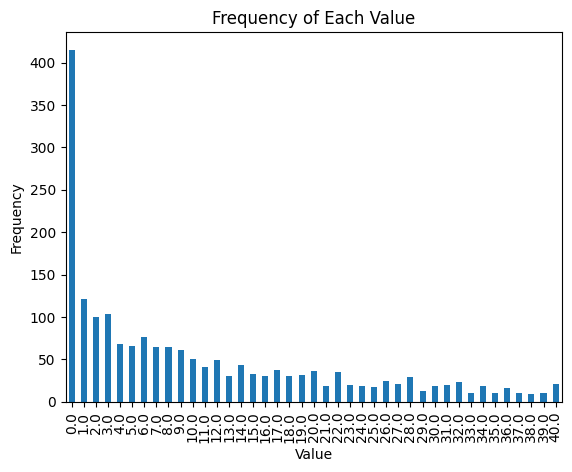

In [19]:
# Count frequencies of each unique value
counts = incidence['cases'].value_counts().sort_index().loc[0:40]  # sort_index keeps the natural order
# Plot
counts.plot(kind='bar')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Frequency of Each Value')
plt.show()

---

In [22]:
model_n = 23
model = cmdstanpy.CmdStanModel(stan_file=f'1-Models/m{model_n}.stan')

15:12:44 - cmdstanpy - INFO - compiling stan file /Users/lucaratzinger/Desktop/Files/13-Projects/p-dengue/1-Models/m23.stan to exe file /Users/lucaratzinger/Desktop/Files/13-Projects/p-dengue/1-Models/m23
15:12:48 - cmdstanpy - INFO - compiled model executable: /Users/lucaratzinger/Desktop/Files/13-Projects/p-dengue/1-Models/m23


In [250]:
# m1
stan_data = {'ni_n': ni_inc.shape[0],
             'i_n': i_inc.shape[0],

             'ni_n_regions': n_non_isolated_regions,
             'i_n_regions': n_isolated_regions,

             'n_timesteps': inc['date_index'].nunique(),

             'ni_y': ni_inc['cases'].astype(int).tolist(),
             'i_y': i_inc['cases'].astype(int).tolist(),

             'ni_region_index': ni_inc['ni_admin2_index'].astype(int).tolist(),
             'i_region_index': i_inc['i_admin2_index'].astype(int).tolist(),

             'ni_time_index': ni_inc['date_index'].astype(int).tolist(),
             'i_time_index': i_inc['date_index'].astype(int).tolist(),

             'ni_log_pop': ni_inc['log_pop'].tolist(),
             'i_log_pop': i_inc['log_pop'].tolist(),

             'W': non_isolated_W,
             'D': non_isolated_D
             }

In [251]:
# m2
stan_data = {'ni_n': ni_inc.shape[0],
             'i_n': i_inc.shape[0],

             'ni_n_regions': n_non_isolated_regions,
             'i_n_regions': n_isolated_regions,

             'n_timesteps': inc['date_index'].nunique(),

             'ni_y': ni_inc['cases'].astype(int).tolist(),
             'i_y': i_inc['cases'].astype(int).tolist(),

             'ni_region_index': ni_inc['ni_admin2_index'].astype(int).tolist(),
             'i_region_index': i_inc['i_admin2_index'].astype(int).tolist(),

             'ni_time_index': ni_inc['date_index'].astype(int).tolist(),
             'i_time_index': i_inc['date_index'].astype(int).tolist(),

             'ni_log_pop': ni_inc['log_pop'].tolist(),
             'i_log_pop': i_inc['log_pop'].tolist(),

             'W_n': W_n,
             'W_sparse': W_sparse,
             'W_weight': W_weight,
             'diag_D': non_isolated_D_diag
             }

In [837]:
# m3
stan_data = {'ni_n': ni_inc.shape[0],
             'i_n': i_inc.shape[0],

             'ni_n_regions': n_non_isolated_regions,
             'i_n_regions': n_isolated_regions,

             'n_timesteps': inc['date_index'].nunique(),

             'ni_y': ni_inc['cases'].astype(int).tolist(),
             'i_y': i_inc['cases'].astype(int).tolist(),

             'ni_region_index': ni_inc['ni_admin2_index'].astype(int).tolist(),
             'i_region_index': i_inc['i_admin2_index'].astype(int).tolist(),

             'ni_time_index': ni_inc['date_index'].astype(int).tolist(),
             'i_time_index': i_inc['date_index'].astype(int).tolist(),

             'ni_log_pop': ni_inc['log_pop'].tolist(),
             'i_log_pop': i_inc['log_pop'].tolist(),

             'W_n': W_n,
             'W_sparse': W_sparse,
             'D_diag': non_isolated_D_diag,
             'lambda': weighted_eigenvalues.tolist()
             }

In [842]:
surv_value = 'surveillance_pop_pct'
# m3
stan_data = {'ni_n': ni_inc.shape[0],
             'i_n': i_inc.shape[0],

             'ni_n_regions': n_non_isolated_regions,
             'i_n_regions': n_isolated_regions,

             'n_timesteps': inc['date_index'].nunique(),

             'ni_y': ni_inc['cases'].astype(int).tolist(),
             'i_y': i_inc['cases'].astype(int).tolist(),

             'ni_region_index': ni_inc['ni_admin2_index'].astype(int).tolist(),
             'i_region_index': i_inc['i_admin2_index'].astype(int).tolist(),

             'ni_time_index': ni_inc['date_index'].astype(int).tolist(),
             'i_time_index': i_inc['date_index'].astype(int).tolist(),

             'ni_log_pop': ni_inc['log_pop'].tolist(),
             'i_log_pop': i_inc['log_pop'].tolist(),

             'ni_log_surv': np.log(ni_inc[surv_value]).tolist(),
             'i_log_surv': np.log(i_inc[surv_value]).tolist(),


             'W_n': W_n,
             'W_sparse': W_sparse,
             'D_diag': non_isolated_D_diag,
             'lambda': weighted_eigenvalues.tolist()
             }

In [846]:
surv_value = 'surveillance_pop_pct'
urb_value = 'urban_pop_pct'
# m16
stan_data = {'ni_n': ni_inc.shape[0],
             'i_n': i_inc.shape[0],

             'ni_n_regions': n_non_isolated_regions,
             'i_n_regions': n_isolated_regions,

             'n_timesteps': inc['date_index'].nunique(),

             'ni_y': ni_inc['cases'].astype(int).tolist(),
             'i_y': i_inc['cases'].astype(int).tolist(),

             'ni_region_index': ni_inc['ni_admin2_index'].astype(int).tolist(),
             'i_region_index': i_inc['i_admin2_index'].astype(int).tolist(),

             'ni_time_index': ni_inc['date_index'].astype(int).tolist(),
             'i_time_index': i_inc['date_index'].astype(int).tolist(),

             'ni_log_pop': ni_inc['log_pop'].tolist(),
             'i_log_pop': i_inc['log_pop'].tolist(),

             'ni_log_surv': np.log(ni_inc[surv_value]).tolist(),
             'i_log_surv': np.log(i_inc[surv_value]).tolist(),

             'ni_urb': (ni_inc[urb_value]/100).tolist(),
             'i_urb': (i_inc[urb_value]/100).tolist(),


             'W_n': W_n,
             'W_sparse': W_sparse,
             'D_diag': non_isolated_D_diag,
             'lambda': weighted_eigenvalues.tolist()
             }

In [874]:
surv_value = 'surveillance_pop_pct'
urb_value = 'urban_pop_pct'
# m18
stan_data = {'ni_n': ni_inc.shape[0],
             'i_n': i_inc.shape[0],

             'ni_n_regions': n_non_isolated_regions,
             'i_n_regions': n_isolated_regions,

             'n_timesteps': inc['date_index'].nunique(),

             'ni_y': ni_inc['cases'].astype(int).tolist(),
             'i_y': i_inc['cases'].astype(int).tolist(),

             'ni_region_index': ni_inc['ni_admin2_index'].astype(int).tolist(),
             'i_region_index': i_inc['i_admin2_index'].astype(int).tolist(),

             'ni_time_index': ni_inc['date_index'].astype(int).tolist(),
             'i_time_index': i_inc['date_index'].astype(int).tolist(),

             'ni_log_pop': ni_inc['log_pop'].tolist(),
             'i_log_pop': i_inc['log_pop'].tolist(),

             'ni_log_surv': np.log(ni_inc[surv_value]).tolist(),
             'i_log_surv': np.log(i_inc[surv_value]).tolist(),

             'ni_urb': (ni_inc[urb_value]/100).tolist(),
             'i_urb': (i_inc[urb_value]/100).tolist(),

             'ni_urb_dens_X_u': ((ni_inc['urban_density'] * ni_inc['urban_pop_pct']/100)/np.std((ni_inc['urban_density'] * ni_inc['urban_pop_pct']/100))).tolist(),
             'i_urb_dens_X_u': ((i_inc['urban_density'] * i_inc['urban_pop_pct']/100)/np.std((i_inc['urban_density'] * i_inc['urban_pop_pct']/100))).tolist(),


             'W_n': W_n,
             'W_sparse': W_sparse,
             'D_diag': non_isolated_D_diag,
             'lambda': weighted_eigenvalues.tolist()
             }

In [ ]:
surv_value = 'surveillance_pop_pct'
urb_value = 'urban_pop_pct'
# m22 alt (no multiplying density by urpan pop pct, makes little difference in fitting)
stan_data = {'ni_n': ni_inc.shape[0],
             'i_n': i_inc.shape[0],

             'ni_n_regions': n_non_isolated_regions,
             'i_n_regions': n_isolated_regions,

             'n_timesteps': inc['date_index'].nunique(),

             'ni_y': ni_inc['cases'].astype(int).tolist(),
             'i_y': i_inc['cases'].astype(int).tolist(),

             'ni_region_index': ni_inc['ni_admin2_index'].astype(int).tolist(),
             'i_region_index': i_inc['i_admin2_index'].astype(int).tolist(),

             'ni_time_index': ni_inc['date_index'].astype(int).tolist(),
             'i_time_index': i_inc['date_index'].astype(int).tolist(),

             'ni_log_pop': ni_inc['log_pop'].tolist(),
             'i_log_pop': i_inc['log_pop'].tolist(),

             'ni_log_surv': np.log(ni_inc[surv_value]).tolist(),
             'i_log_surv': np.log(i_inc[surv_value]).tolist(),

             'ni_urb': (ni_inc[urb_value]/100).tolist(),
             'i_urb': (i_inc[urb_value]/100).tolist(),

             'ni_urb_dens_X_u': (ni_inc['urban_density']/np.std((ni_inc['urban_density']))).tolist(),
             'i_urb_dens_X_u': (i_inc['urban_density']/np.std((i_inc['urban_density']))).tolist(),


             'W_n': W_n,
             'W_sparse': W_sparse,
             'D_diag': non_isolated_D_diag,
             'lambda': weighted_eigenvalues.tolist()
             }

In [50]:
# m23
surv_value = 'surveillance_pop_pct'
urb_value = 'urban_pop_pct'

input = np.array(ni_inc['mean_temp'])
order = 3
knots = np.linspace(np.min(input), np.max(input), 5)
B_ni = spline_values(input, order, ext_knots=np.concatenate((np.repeat(knots[0], order-1), knots, np.repeat(knots[-1], order-1))))
input = np.array(i_inc['mean_temp'])
knots = np.linspace(np.min(input), np.max(input), 5)
B_i = spline_values(input, order, ext_knots=np.concatenate((np.repeat(knots[0], order-1), knots, np.repeat(knots[-1], order-1))))

stan_data = {'ni_n': ni_inc.shape[0],
             'i_n': i_inc.shape[0],

             'ni_n_regions': n_non_isolated_regions,
             'i_n_regions': n_isolated_regions,

             'n_timesteps': inc['date_index'].nunique(),

             'ni_y': ni_inc['cases'].astype(int).tolist(),
             'i_y': i_inc['cases'].astype(int).tolist(),

             'ni_region_index': ni_inc['ni_admin2_index'].astype(int).tolist(),
             'i_region_index': i_inc['i_admin2_index'].astype(int).tolist(),

             'ni_time_index': ni_inc['date_index'].astype(int).tolist(),
             'i_time_index': i_inc['date_index'].astype(int).tolist(),

             'ni_log_pop': ni_inc['log_pop'].tolist(),
             'i_log_pop': i_inc['log_pop'].tolist(),

             'ni_log_surv': np.log(ni_inc[surv_value]).tolist(),
             'i_log_surv': np.log(i_inc[surv_value]).tolist(),

             'ni_urb': (ni_inc[urb_value]/100).tolist(),
             'i_urb': (i_inc[urb_value]/100).tolist(),

             'B_n': B_ni.shape[1],
             'B_ni': B_ni,
             'B_i': B_i
             }

In [51]:
fit = model.sample(data=stan_data, iter_sampling=4000, iter_warmup=4000, chains=2, show_console=False, seed=123)

15:17:22 - cmdstanpy - INFO - CmdStan start processing


chain 1:   0%|          | 0/8000 [00:00<?, ?it/s, (Warmup)]

chain 2:   0%|          | 0/8000 [00:00<?, ?it/s, (Warmup)]

15:18:55 - cmdstanpy - INFO - CmdStan done processing.


In [53]:
fit.summary()

,Mean,MCSE,StdDev,MAD,5%,50%,95%,ESS_bulk,ESS_tail,ESS_bulk/s,R_hat
lp__,-10473.400000,0.043730,2.163280,2.013370,-10477.500000,-10473.100000,-10470.500000,2644.10,4297.82,26.5870,1.000230
beta_0,-11.721900,0.009987,0.418056,0.423068,-12.411200,-11.721500,-11.038000,1759.56,2738.39,17.6927,1.001260
beta_urb,-0.832898,0.001104,0.088374,0.088616,-0.977353,-0.832891,-0.687054,6434.84,5469.67,64.7036,0.999939
alpha[1],-2.878640,0.010572,0.737386,0.741412,-4.053510,-2.890810,-1.644170,4865.37,5009.13,48.9223,1.000420
alpha[2],-1.287270,0.010272,0.745167,0.741550,-2.496870,-1.301840,-0.036930,5298.38,5321.76,53.2763,1.000250
alpha[3],-2.152240,0.010780,0.481130,0.482532,-2.955790,-2.144810,-1.369210,1989.81,3323.93,20.0079,1.001430
alpha[4],-1.696150,0.009928,0.424180,0.424886,-2.396490,-1.694880,-0.999965,1831.59,2918.85,18.4171,1.000690
alpha[5],-1.125350,0.010137,0.437261,0.434899,-1.845460,-1.122940,-0.408880,1864.00,3032.20,18.7429,1.001410
alpha[6],-1.504220,0.010153,0.480406,0.492516,-2.282400,-1.500580,-0.727924,2247.38,3544.35,22.5979,1.000670
disp,0.568861,0.000207,0.016500,0.016504,0.542195,0.568636,0.596353,6417.30,5112.99,64.5273,1.000230


In [54]:
# read draws
draws = fit.draws_pd()
draws.to_csv(f'1-Models/m{model_n}_draws.csv')

In [55]:
draws = pd.read_csv(f'1-Models/m{model_n}_draws.csv')

---

### Splines

In [56]:
input = np.linspace(np.min(np.array(ni_inc['mean_temp'])), np.max(np.array(ni_inc['mean_temp'])), 1000)
knots = np.linspace(np.min(input), np.max(input), 5)
B = spline_values(input[:-1], order, ext_knots=np.concatenate((np.repeat(knots[0], order-1), knots, np.repeat(knots[-1], order-1))))

In [57]:
alpha_mean = np.array(draws[[f'alpha[{i}]' for i in range(1, B.shape[1]+1)]].mean(axis=0))

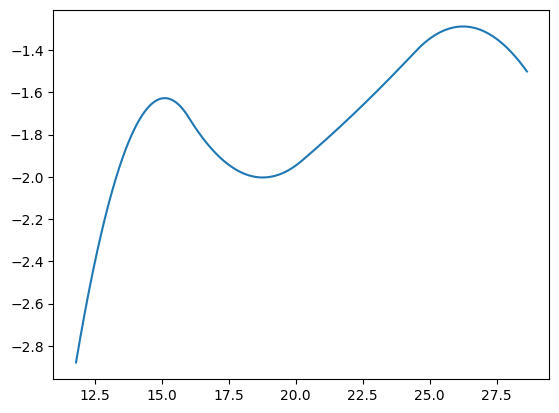

In [58]:
plt.plot(input[:-1], (alpha_mean.reshape(1, -1) * B).sum(axis=1))
plt.show()

---

### Noise

In [582]:
# select noise variables and calculate posterior mean and variance
ni_eps_cols = [f"ni_eps[{i}]" for i in ni_inc.index]
ni_eps_samples = draws[ni_eps_cols].multiply(draws["eps_std"], axis=0)

ni_eps_summary = pd.DataFrame({
    "mean": ni_eps_samples.mean(axis=0),
    "std": ni_eps_samples.std(axis=0)
})
ni_eps_summary.index = range(1, len(ni_eps_summary)+1)

i_eps_cols = [f"i_eps[{i}]" for i in i_inc.index]
i_eps_samples = draws[i_eps_cols].multiply(draws["eps_std"], axis=0)

i_eps_summary = pd.DataFrame({
    "mean": i_eps_samples.mean(axis=0),
    "std": i_eps_samples.std(axis=0)
})
i_eps_summary.index = range(1, len(i_eps_summary)+1)


In [584]:
np.mean(y_eps['mean'])

np.float64(-2.860040611820831e-05)

In [583]:
# merge to data dataframes and finally to one single unified data y + noise eps summary matrix
ni_y_eps = pd.merge(ni_inc, ni_eps_summary, left_index=True, right_index=True)
i_y_eps = pd.merge(i_inc, i_eps_summary, left_index=True, right_index=True)

y_eps = pd.concat([ni_y_eps, i_y_eps])
y_eps = y_eps.sort_values(by=['date_index', 'admin2_index'])

// extract ni_eps and i_eps samples
ni_eps_samples = fit.stan_variable('ni_eps')
i_eps_samples = fit.stan_variable('i_eps')
eps_var_samples = fit.stan_variable('eps_var')

// make a zero array of size (n_samples, n_regions)
eps_full_samples = np.zeros((ni_eps_samples.shape[0], n_non_isolated_regions + n_isolated_regions))
for idx, region_idx in enumerate(non_isolated_regions):
    eps_full_samples[:, region_idx] = ni_eps_samples[:, idx] * eps_var_samples
for idx, region_idx in enumerate(isolated_regions):
    eps_full_samples[:, region_idx] = i_eps_samples[:, idx] * eps_var_samples

// make a dataframe pivot table of ni_eps_full_samples
// use the index to name dictionary to get admin2 names
eps_df = pd.DataFrame(eps_full_samples, columns=[admin2_dict[i+1] for i in range(n_non_isolated_regions + n_isolated_regions)])

In [755]:
def noise_instance_map(samples, date_index, scale=2, vmin=None, vmax=None, print_range=False, saveto=None):
    valid_admin = pd.read_csv(f'0-Data/base_info/admin{scale}_unique.csv', header=None)[0].tolist()
    
    # Read shapefile
    admin_shp = gpd.read_file(f"0-Data/dengue_indonesia_yifan/data/shapefiles/admin{scale}/admin{scale}_38.shp")
    # drop invalid admin2 regions
    admin_shp = admin_shp[admin_shp[f'admin{scale}'].isin(valid_admin)]
    other_shp = gpd.read_file("0-Data/dengue_indonesia_yifan/data/shapefiles/other/idn_neighbours.shp")

    value = 'std'
    df = samples[samples['date_index']==date_index][['admin2', value]]

    # merge data on admin column
    admin_ir = admin_shp.merge(df, left_on=f"admin{scale}", right_on=f"admin{scale}", how="left")
    # admin_ir = admin_ir.to_crs("ESRI:102027")

    fig, ax = plt.subplots(figsize=(12, 5))

    admin_ir.plot(
        column=value,   # value to plot
        cmap="viridis",       # same style as your R example 
        # log viridis scale
        # norm=plt.matplotlib.colors.LogNorm(vmin=vmin, vmax=vmax) if (vmin is not None and vmax is not None) else None,

        linewidth=0.2,
        edgecolor="black",
        legend=True,
        vmin=vmin,
        vmax=vmax,
        ax=ax,
        missing_kwds={
        "color": "pink",
        "label": "No Data",
    }
    )

    other_shp.boundary.plot(ax=ax, color="black", linewidth=0.1)
    # ax.set_title(f"Admin level {scale}: {variable} for {time.strftime('%Y-%m')}", fontsize=10)
    ax.set_axis_off()

    # define plot boundaries
    minx, miny, maxx, maxy = admin_ir.total_bounds
    ax.set_xlim(minx - 1, maxx + 1)
    ax.set_ylim(miny - 1, maxy + 1)

    if saveto:
        plt.savefig(saveto, bbox_inches='tight', dpi=300)

    plt.show()

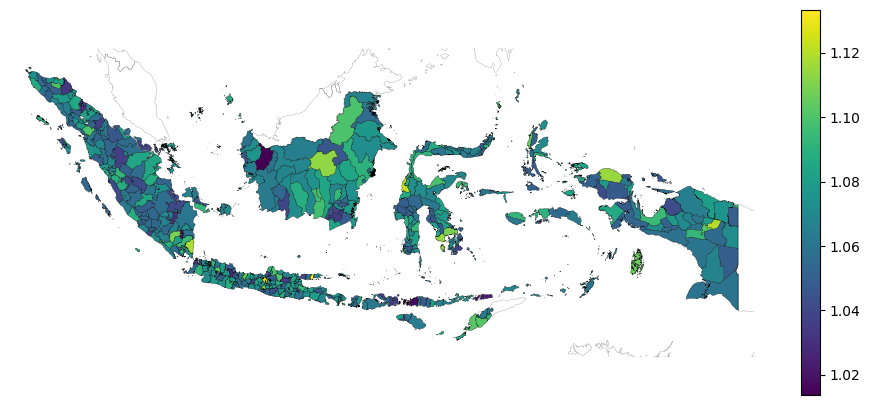

In [756]:
noise_instance_map(y_eps, date_index=4)